In [1]:
import openvsp as vsp
import time
import scipy
import os
import shutil
import csv
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
from CODE.basicgeo import P2, P3, interpP3
import ezdxf
from CODE.dxfgrouping import filterlayerelements, makemergevertset, linearizeelement
from CODE.dxfgrouping import getblockcomponent, dxfoutputblocks
from CODE.VSPutils import generateWing, v2CL, analyseVLM, getResults, getLod, trimCG, calcLTEpts, calcTLpts, calcTwists, Crz,findBillow, calcALLpts, calcTLF, OPdatFile

stdout = vsp.cvar.cstdout
errorMgr = vsp.ErrorMgrSingleton.getInstance()
vsp.GetVSPVersion()

'OpenVSP 3.40.1'

In [2]:
def sec2ords(pts, LEind):
    """Function to give list of normalised P2 values for aerofoil ordinates when given a list of points and the index of the Leading Edge point in the list"""
    ords = []
    vLT = pts[LEind] - pts[0]
    for pt in pts:
        vLP = pts[LEind] - pt
        lam = P3.Dot(vLT,vLP)/vLT.Lensq()
        d = lam * vLT.Len()
        h = vLP.Lensq() - d**2
        if h > 0:
            h = np.sqrt(h)
        else:
            h = 0
        y = P3.Cross(vLP,vLT).y
        if y != 0:
            sign = abs(y)/y
        else:
            sign = 0
        ords.append(P2(lam,sign*h/vLT.Len()))
    return ords


def xyz2GliderDict(fname, AFfolder, scale=1, thick = 1e-3, wingletSec = None):
    """Function to convert csv of xyz points into a folder of aerofoil files and a gliderDict"""
    k = list(csv.reader(open(fname)))
    wingmeshuvudivisions = eval(k[0][-3])
    assert (wingmeshuvudivisions == len(k[0])/3-1), 'Section numbering incorrect'
    Sproj, Stot = 0, 0
    AFs, zvals,secs, chordsmm, sweeps, dihedrals, twists, ds = [], [], [], [], [], [], [], []
    LEind = False
    surf = []
    if wingletSec:
        dslim = wingletSec
    else:
        dslim = (wingmeshuvudivisions*3)+2
    for i in range(0, (wingmeshuvudivisions*3)+2, 3):
        pts = []
        bVert = True
        for j in range(2, len(k)):
            pts.append(P3(float(k[j][i])*scale, float(k[j][i+1])*scale, float(k[j][i+2])*scale))
            #Find out if the section is vertical 
            if len(pts)>1:
                if pts[-1].y != pts[-2].y:
                    bVert = False
            #Find the index position of the LE highlight. NOTE: this assumes that all sections have the LE highlight at the same index location.
            if not LEind:
                if float(k[j+1][i]) > pts[-1].x:
                    LEind =j-2
        c = pts[0].x - pts[LEind].x
        chordsmm.append(c)
        pts[0] = pts[-1]
        # Find furthest back point where top and bottom surfaces are coincident
        if len(chordsmm) < dslim+1:
            dsp = pts[0]
            DSind = 0
            for j in range(int(len(pts)/2)):
                vTB = pts[j] - pts[-j-1]
                if vTB.Len()/c < thick:
                    dsp = pts[j]
                    DSind = j
            # Move points apart by tapering amount, max tol
            #for j in range(1,DSind+1):
            #    if (pts[0] - dsp).Len() > 0:
            #        r = (pts[0] - pts[j]).Len() / (pts[0] - dsp).Len()
            #        pts[j] = pts[j] + P3(0,0,c*(1e-3+((r**2)*thick)))
        surf.append(pts)
        vCh = pts[LEind]-pts[0]
        twists.append(-np.degrees(np.arctan(vCh.z/vCh.x)))
        if len(surf)>1:
            vLE = surf[-1][LEind] - surf[-2][LEind]
            s = np.sqrt(vLE.y**2 + vLE.z**2)
            secs.append(secs[-1]+s)
            sweeps.append(np.degrees(np.arctan(vLE.x/s)))
            dihedrals.append(np.degrees(np.arctan(vLE.z/vLE.y)))
            Sproj += vLE.y * (chordsmm[-1]+chordsmm[-2])/2
            Stot += (secs[-1]-secs[-2]) * (chordsmm[-1]+chordsmm[-2])/2
        else:
            secs.append(pts[LEind].y)
            
        ords = sec2ords(pts, LEind)
        AFfname = AFfolder + str(int(i/3)) + '.dat'
        OPdatFile(ords, AFfname)
        AFs.append(AFfname)
        ds.append(dsp.x - pts[LEind].x)
    Stot *= 2e-6
    Sproj *= 2e-6
    print('Projected wing area: {S}'.format(S = round(Sproj,2)))
    print('Total wing area: {S}'.format(S = round(Stot,2))) 
    print('Leading edge index',LEind)
    return {'secs':secs, 'chordsmm':chordsmm, 'sweeps':sweeps, 'dihedrals':dihedrals, 'twists':twists, 'ds':ds, 'AFs':AFs, 'rs':[], 'Stot':Stot, 'Sproj':Sproj}, surf

In [3]:
def generateWing(wingDict, template, AFfolder, maxThick = None, t_min = None):
    vsp.ReadVSPFile(template)
    spans = []
    chords =[]
    dSurfs =[]
    
    for i in range(1,len(wingDict['secs'])):
        spans.append((wingDict['secs'][i]-wingDict['secs'][i-1])/1000)
    
    for i in range(len(wingDict['chordsmm'])):
        chords.append(wingDict['chordsmm'][i]/1000)
        dSurfs.append(wingDict['ds'][i]/wingDict['chordsmm'][i])

    assert len(wingDict['rs']) == len(wingDict['AFs']) or len(wingDict['secs']) == len(wingDict['AFs']), 'Must either specify an aerofoil for every section or an r (ratio of span) for interpolating sections'
    if len(wingDict['secs']) != len(wingDict['AFs']):
        secpts = []
        for AF in wingDict['AFs']:
            secpts.append(np.loadtxt(AF, delimiter = ','))
        AFs = []
        for i in range(len(wingDict['secs'])):
            pts=interpolate_section(wingDict['secs'][i]/wingDict['secs'][-1], secpts, wingDict['rs'])
            if t_min is not None:
                t=t_min/chordsmm[i]
                pts = convertDS(pts,dSurfs[i], 50/wingDict['chordsmm'][0], t)
            else:
                t = 0.001
                pts = convertDS(pts,dSurfs[i], 50/wingDict['chordsmm'][0], t)
            thick = findThickness(pts)
            #print('thickness',thick)
            if maxThick is not None and thick > maxThick:
                pts = scaleSection(pts, scaleTH = maxThick/thick, minthick = t)
            AFfname = AFfolder+str(i)+'.dat'
            OPdatFile(pts, AFfname) # !!!!NOTE: WILL NEED TO MODIFY OTHER FUNCTIONS THAT USE THIS TO SEND AFfolder as a string including the path!!!!
            AFs.append(AFfname)
    else:
        AFs = wingDict['AFs']
        
    
    wid = vsp.AddGeom( "WING", "" )
    vsp.SetGeomName( wid, "FreeCAD wing")
    
    for i in range(len(spans)):
        vsp.InsertXSec( wid, 1, vsp.XS_FILE_AIRFOIL)
        vsp.Update()
    
    
    
    vsp.CutXSec(wid, 1)
    xsec_surf = vsp.GetXSecSurf(wid, 0 )
    vsp.ChangeXSecShape(xsec_surf, 0, vsp.XS_FILE_AIRFOIL) # Change root section to AF file
    xsec = vsp.GetXSec(xsec_surf, 0)
    AFname = AFs[0]
    #print(AFname)
    vsp.ReadFileAirfoil(xsec, AFname)
    vsp.Update()
    
    vsp.SetDriverGroup( wid, 1, 1, 5, 6)
    
    xsec = vsp.GetXSec(xsec_surf, i)
    xsecstr = "XSec_0"
    vsp.SetParmVal(wid, "Twist_Location",  xsecstr, 0)
    vsp.SetParmVal(wid, "Twist",  xsecstr, wingDict['twists'][0]) # Set root incidence
    
    for i in range(len(spans)):
        xsec = vsp.GetXSec(xsec_surf, i)
        AFname = AFs[i]
        vsp.ReadFileAirfoil(xsec, AFname)
        #print(AFname)
        xsecstr = "XSec_"+ str(i+1)
        vsp.SetParmVal(wid, "Root_Chord", xsecstr, chords[i])
        vsp.SetParmVal(wid, "Sweep", xsecstr, wingDict['sweeps'][i])
        vsp.SetParmVal(wid, "Sweep_Location", xsecstr, 0)
        vsp.SetParmVal(wid, "Span",  xsecstr, spans[i])
        vsp.SetParmVal(wid, "Dihedral",  xsecstr, wingDict['dihedrals'][i])
        vsp.SetParmVal(wid, "Twist",  xsecstr, wingDict['twists'][i+1])
        vsp.SetParmVal(wid, "Twist_Location",  xsecstr, 0)
        if i == len(spans)-1:
            vsp.SetParmVal( wid, "Tip_Chord", xsecstr, chords[-1])
            xsec = vsp.GetXSec(xsec_surf, i+1)
            AFname = AFs[i+1]
            vsp.ReadFileAirfoil(xsec, AFname)
        vsp.Update()
    S = vsp.GetParmVal( wid, "TotalArea", "WingGeom")
    print('Wing generated with', len(spans), 'points', 'Area = ',S)

def interpolate_section(r,secpts,rs):
	assert len(secpts) == len(rs), 'Must a position for every section'
	for pts in secpts:
		assert len(pts) == len(secpts[0]), 'sections must contain same number of points'
	OPpts = []
	for i in range(len(secpts[0])):
		ys = []
		for j in range(len(secpts)):
			assert secpts[j][i][0] == secpts[0][i][0], 'sections must have matching x ordinates'
			ys.append(secpts[j][i][1])
		y = np.interp(r, rs, ys)
		OPpts.append((secpts[0][i][0], y))
	return OPpts

def convertDS(pts,ds, seam,tol=0.01):
    l=len(pts)
    aerof=[]
    dsp = [ds,0]
    dsfp = [seam,0]
    found = False
    front = False
    foundSeam = False
    pl = pts[0]
    highlight=False
    sSurfpts =[]
	
    for p in pts:
        if ds >= 1: #What to do if 100% double surface
            return pts
        elif p[0] < ds and not found:
            dsp[1] = p[1] + ((ds-p[0])*(pl[1]-p[1]))/(pl[0]-p[0])
            found = True
            #print(dsp)
        if not found:
            sSurfpts.insert(0,P2(p[0],p[1]-tol))
            
        if not highlight and p[0]>pl[0]:
            highlight = True
            #print('found highlight',pl)
        
        if highlight and p[0] > seam:
            if not foundSeam:
                #dsfp[0] = p[0]
                #dsfp[1]= p[1] + ((seam-p[0])*(pl[1]-p[1]))/(pl[0]-p[0])
                dsfp = p
                #print('foundseam',dsfp)
                foundSeam = True
            
            if p[0]<dsp[0]:
                y = np.interp(p[0],[dsfp[0],dsp[0]],[dsfp[1],dsp[1]])
                aerof.append(P2(p[0],y)) 
            else:
                return aerof + sSurfpts
  
        else:
            aerof.append(P2(p[0],p[1]))
        pl = p
    return aerof

def findThickness(sec):
    upper = [P2(sec[0][0],sec[0][1])]
    lower = [P2(0,0)]
    thick = []
    
    for i in range(1,len(sec)):
        if sec[i][0]<sec[i-1][0]:
            upper.append(P2(sec[i][0],sec[i][1]))
        else:
            lower.append(P2(sec[i][0],sec[i][1]))

    for pt in upper:
        ptL1 = lower[0]
        for i in range(len(lower)):
            ptL2 = lower[i]
            if ptL1.u<=pt.u<ptL2.u:
                break
            ptL1 = ptL2
        if ptL1.u == ptL2.u:
            r = 0
        else:
            r = (pt.u-ptL1.u) / (ptL2.u-ptL1.u)
        v = ptL2-ptL1
        ptL = ptL1 + v*r
        thick.append((pt-ptL).Len())
        
    return max(thick)

In [4]:
folder = '/home/timbo/myrepos/gitlab/wildcat/Raw Geometry/'
fname = folder+"P7Wildcat-240924.csv"
P7HA,surf = xyz2GliderDict(fname, folder+'AF/', scale =0.072, thick = 3.5e-3, wingletSec=26)
#P7HA['dihedrals'][0] = 0
P7HA

Projected wing area: 0.0
Total wing area: 0.0
Leading edge index 1


{'secs': [0.0,
  np.float64(13.66641556460309),
  np.float64(27.32290574304421),
  np.float64(40.96985662212647),
  np.float64(54.607665894390614),
  np.float64(68.23674385619191),
  np.float64(81.85751248262959),
  np.float64(95.46986214190962),
  np.float64(109.07512156874249),
  np.float64(123.08787913233242),
  np.float64(137.09228454624844),
  np.float64(151.09392355556727),
  np.float64(165.09479074216037),
  np.float64(179.09537019874986),
  np.float64(193.09575640359293),
  np.float64(207.09598277135214),
  np.float64(221.096096050986),
  np.float64(235.09614573181065),
  np.float64(249.09616738023124),
  np.float64(263.0961803295448),
  np.float64(277.0961926227178),
  np.float64(291.09656486246104),
  np.float64(305.0966335144849),
  np.float64(319.09768352893485),
  np.float64(333.10343187879664),
  np.float64(347.11240324301366),
  np.float64(361.1211697200231),
  np.float64(373.6209162676362),
  np.float64(380.86089759489886),
  np.float64(388.2268050020809),
  np.float64(

In [60]:
path = os.getcwd()+'/'
template = 'HAtemplate.vsp3'
folder = '/home/timbo/myrepos/gitlab/wildcat/VSP/'
AFfolder = 'AF/'
#AFfolder = 'data/aerofoils/3E140/'
vsp.VSPRenew()

generateWing(P7HA, (folder+template), folder + AFfolder, maxThick = None, t_min = None)
fnamenew = 'P7Wildcat-.vsp3'
vsp.WriteVSPFile(folder+fnamenew)

Wing generated with 30 points Area =  13.893067059404471


In [5]:
#pts = surf[22]
#LEind = 30
#c = (pts[0]-pts[LEind]).Len()
#print(c)
#thick = 0.001
def makeDSsection(pts, LEind, DSind = None, thick = 0.002):
    c = (pts[0]-pts[LEind]).Len()
    if DSind == None:
        for i in range(len(pts)-1, int(len(pts)/2),-1):
            vTB = pts[i] - pts[-i-1]
            #print(vTB.Len()/c)
            if vTB.Len()/c < thick:
                dsp = pts[i]
                DSind = i
    xs = []
    r = (pts[DSind]-pts[LEind]).x/(pts[0]-pts[LEind]).x
    #print(r)
    xnews = []
    for pt in pts[LEind:]:
        xd = pt.x - pts[LEind].x
        x = xd*r + pts[LEind].x
        xnews.append(x)
    #uspts.append(P3(x,0,pt.z))
    xs = [pt.x for pt in pts[LEind:]]
    zs = [pt.z for pt in pts[LEind:]]
    znews = np.interp(xnews,xs,zs)
    uspts = [P3(x,0,z) for x,z in zip(xnews,znews)]
    newpts = (pts[0:LEind]+uspts)
    return newpts, DSind

# TODO: Manually work out DSinds for sections near the tip m
#       Make function return full section
def makeDSwing(surf, DSinds = None):
    usptss = []
    if DSinds:
        for sec, DSind in zip(surf,DSinds):
            uspts, DSind = makeDSsection(sec, LEind = 30, DSind = DSind, thick = 0.002)
            usptss.append(uspts)
    else:
        DSinds = []
        for sec in surf:
            uspts, DSind = makeDSsection(sec, LEind = 30, DSind = None, thick = 0.002)
            usptss.append(uspts)
            DSinds.append(DSind)
    return usptss, DSinds

newsurf, DSinds = makeDSwing(surf)

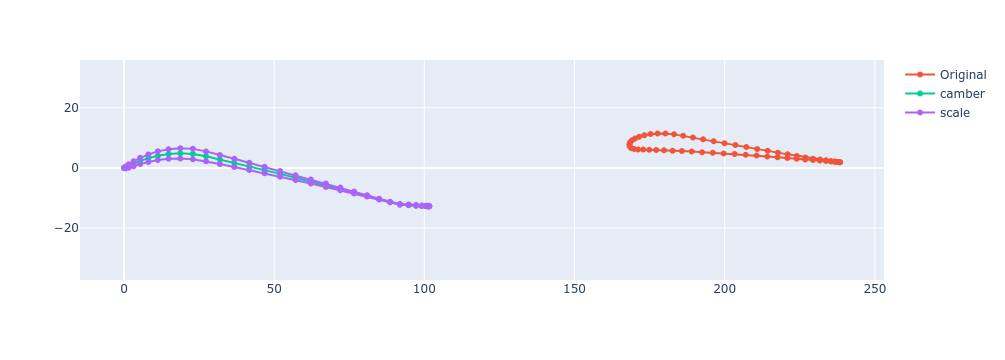

In [12]:
i=25
pts = surf[i]
#uspts = newsurf[i]
fig = px.scatter()
fig.add_trace(go.Scatter(
    x=[pt.x for pt in pts], 
    y=[pt.z for pt in pts], mode = 'lines+markers', name = 'Original'
))
fig.add_trace(go.Scatter(
    x=[pt.x for pt in camber], 
    y=[pt.z for pt in camber], mode = 'lines+markers', name = 'camber'
))
fig.add_trace(go.Scatter(
    x=[pt.x for pt in scalesec], 
    y=[pt.z for pt in scalesec], mode = 'lines+markers', name = 'scale'
))
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

In [6]:
newsurf, DSinds = makeDSwing(surf, DSinds)

In [7]:
LEind = 30
uspts = usptss[0]
sec = surf[0]
print(len(uspts), len(sec))
uspts[0],sec[0]
newsec = (sec[0:LEind]+uspts)

NameError: name 'usptss' is not defined

In [8]:
def scaleSection(sec, scaleTH, LEind, minthick = 0):
    #sec = [P2(v.x,v.z) for v in secvec]
    upper = sec[:LEind]
    lower = sec[LEind:]
    camber = []
    upper_scaled = []
    lower_scaled = []
    
    #for i in range(1,len(sec)):
    #    if sec[i].u<sec[i-1].u:
    #        upper.append(sec[i])
    #    else:
    #        lower.append(sec[i])

    for pt in upper:
        ptL1 = lower[0]
        for i in range(len(lower)):
            ptL2 = lower[i]
            if ptL1.x<=pt.x<ptL2.x:
                break
            ptL1 = ptL2
        if ptL1.x == ptL2.x:
            r = 0
        else:
            r = (pt.x-ptL1.x) / (ptL2.x-ptL1.x)
        v = ptL2-ptL1
        ptL = ptL1 + v*r
        #print(ptL1,ptL,ptL2,r)
        ptC = pt - (pt-ptL)*0.5 #point on camber line
        camber.append(ptC)
        ptUsc = P3((pt.x),0,(ptC.z + max(minthick/2, scaleTH*(pt.z-ptC.z))))
        ptLsc = P3((ptL.x),0,(ptC.z - max(minthick/2, scaleTH*(ptC.z-ptL.z))))
        upper_scaled.append(ptUsc)
        lower_scaled.insert(0,ptLsc)
    camber.append(sec[LEind])
    scaled = upper_scaled + [sec[LEind]] + lower_scaled
    #scaledvec = [P3(pt.u, secvec[0].y, pt.v) for pt in scaled]        
    return scaled, camber

scalesec,camber = scaleSection(surf[0], 0.2, 30, minthick = 0.2)

In [9]:
len(surf[0]), len(scalesec)

(61, 61)

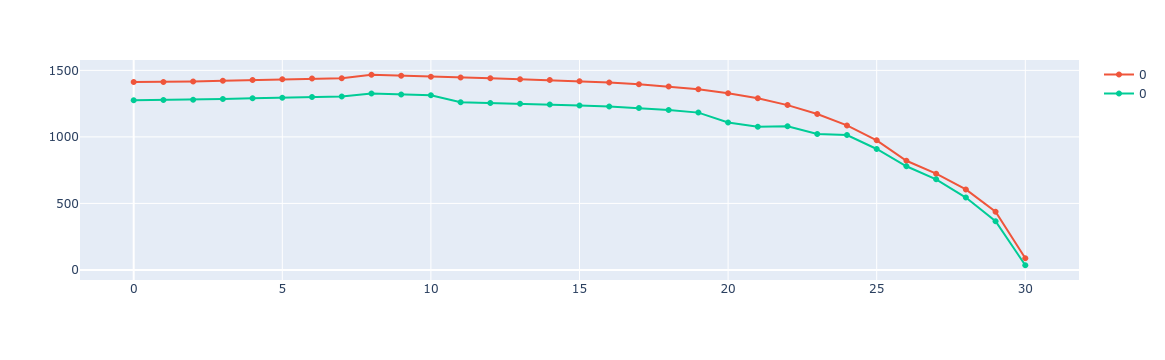

In [40]:
i=1
fig = px.line()
fig.add_trace(go.Scatter(
    y = P7HA['chordsmm'], x = list(range(len(P7HA['secs']))),mode = 'lines+markers', name = '0'
))
fig.add_trace(go.Scatter(
    y = P7HA['ds'], x = list(range(len(P7HA['secs']))),mode = 'lines+markers', name = '0'
))
fig.show()

# Stability analysis

In [78]:
#Yaw stability:
P7W_240907 = {'Beta':[
                    -2,
                    -1.6,
                    -1.2,
                    -0.8,
                    -0.4,
                    0,
                    0.4,
                    0.8,
                    1.2,
                    1.6,
                    2],
              'CMz':[
                  0.000698515964,
                  0.000559154285,
                  0.000421406353,
                  0.000279051331,
                  0.000148559624,
                  0.000000346022,
                  -0.000147214992,
                  -0.000278394489,
                  -0.000420921031,
                  -0.000558765307,
                  -0.000697977086
              ]
             }
P7W_240924 = {'Beta':[
                    -2,
                    -1.6,
                    -1.2,
                    -0.8,
                    -0.4,
                    0,
                    0.4,
                    0.8,
                    1.2,
                    1.6,
                    2],
              'CMz':[
                  0.000635302545,
                  0.000498818389,
                  0.000376860249,
                  0.000250640455,
                  0.000132556782,
                  0.000000886269,
                  -0.000126088254,
                  -0.000248850567,
                  -0.000381904651,
                  -0.000497154839,
                  -0.000633186782
              ]
             }
P7W_240924_nowinglet = {'Beta':[
                    -2,
                    -1.6,
                    -1.2,
                    -0.8,
                    -0.4,
                    0,
                    0.4,
                    0.8,
                    1.2,
                    1.6,
                    2],
              'CMz':[0.000415959597,
                     0.000333406682,
                     0.000249698756,
                     0.000166069959,
                     0.000082594894,
                     -0.000000315096,
                     -0.000081136117,
                     -0.000164591634,
                     -0.000249299282,
                     -0.000333053567,
                     -0.000415573869
                     ],                        
             }

P7W_240925 = {'Beta':[
                    -2,
                    -1.6,
                    -1.2,
                    -0.8,
                    -0.4,
                    0,
                    0.4,
                    0.8,
                    1.2,
                    1.6,
                    2],
              'CMz':[0.000520440289,
                     0.000416355675,
                     0.000316684712,
                     0.000203456381,
                     0.000100382847,
                     -0.000000021082,
                     -0.000100305043,
                     -0.000203420921,
                     -0.000316567857,
                     -0.000416379037,
                     -0.000519982557
                    ]
             }



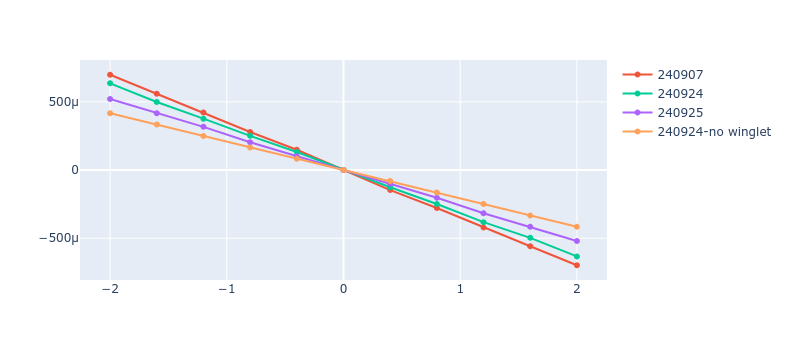

In [86]:
fig = px.line()
fig.add_trace(go.Scatter(
    x = P7W_240907['Beta'],
    y = P7W_240907['CMz'], name = '240907'))

fig.add_trace(go.Scatter(
    x = P7W_240924['Beta'],
    y = P7W_240924['CMz'], name = '240924'))

fig.add_trace(go.Scatter(
    x = P7W_240925['Beta'],
    y = P7W_240925['CMz'], name = '240925'))

fig.add_trace(go.Scatter(
    x = P7W_240924_nowinglet['Beta'],
    y = P7W_240924_nowinglet['CMz'], name = '240924-no winglet'))
fig.show()

In [87]:
wing = P7W_240925
stab = []
for i in range(1,len(wing['Beta'])):
    stab.append((wing['CMz'][i]-wing['CMz'][i-1])/(wing['Beta'][i]-wing['Beta'][i-1]))
    print(stab[-1])
    wing['stab'] = stab

-0.000260211535
-0.0002491774074999999
-0.00028307082750000007
-0.00025768383499999995
-0.00025100982250000003
-0.0002507099025
-0.000257789695
-0.00028286734000000007
-0.0002495279499999999
-0.0002590088000000002


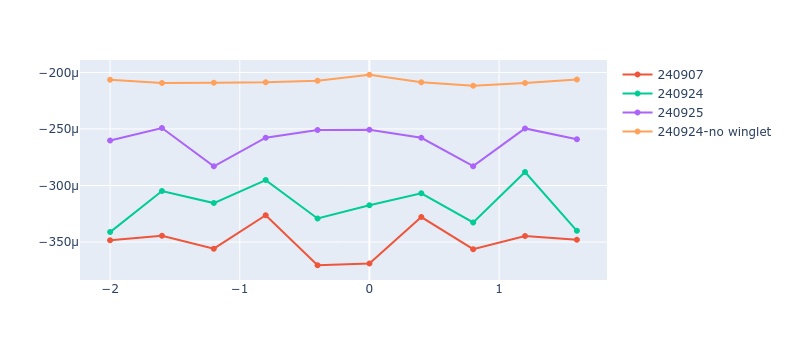

In [88]:
fig = px.line()
fig.add_trace(go.Scatter(
    x = P7W_240907['Beta'],
    y = P7W_240907['stab'], name = '240907'))

fig.add_trace(go.Scatter(
    x = P7W_240924['Beta'],
    y = P7W_240924['stab'], name = '240924'))

fig.add_trace(go.Scatter(
    x = P7W_240925['Beta'],
    y = P7W_240925['stab'], name = '240925'))

fig.add_trace(go.Scatter(
    x = P7W_240924_nowinglet['Beta'],
    y = P7W_240924_nowinglet['stab'], name = '240924-no winglet'))
fig.show()

In [28]:
path = os.getcwd()
fname = '/examples/P7HA-240828.vsp3'
vsp.VSPRenew()
vsp.ReadVSPFile((path+fname))

v1 = 26 * 0.44704 # Convert mph to m/s
v2 = 50 * 0.44704 # Convert mph to m/s
cref = 1.438
Xref = 1.12
Sref = 13.5
L = (78+12+28)*9.81 # Body weight + harness weight + glider weight
CL1 = v2CL(v1,Sref,L)
CL2 = v2CL(v2,Sref,L)
print('v1=',v1,'m/s')
print('CL1:', CL1)
print('v2=',v2,'m/s')
print('CL2:', CL2)

v1= 11.62304 m/s
CL1: 1.036267047984886
v2= 22.352 m/s
CL2: 0.280206609775113


In [29]:
analyseVLM(AoAStart=-5, AoAEnd=5, AlphaNpts=3, Xref = Xref, VLM = True, Sref=None)
res = getResults()

0 / -1.00000   ...  Max:   -0.17586 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     5 / 6     ... GMRES Iter:     1 ... Red:   -0.21552 / -1.00000   ...  Max:   -0.39138 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     5 / 6     ... GMRES Iter:     2 ... Red:   -0.48598 / -1.00000   ...  Max:   -0.66183 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     5 / 6     ... GMRES Iter:     3 ... Red:   -0.80065 / -1.00000   ...  Max:   -0.97651 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     5 / 6     ... GMRES Iter:     4 ... Red:   -1.08252 / -1.00000   ...  Max:   -1.25838 / 1.00000    ... KTRes: 0.00000    
        5   0.00100   5.00000   0.00000   1.08661   0.01773   0.04927   0.06700   0.04688   0.06461   0.00028  16.26790   1.10997  -0.02796   0.00000   1.08832   0.00000  -0.10027   0.00000   0.00000
Wake Iter:     6 / 6     ... GMRES Iter:     0 ... Red:    0.00000 / -1.00000   ...  Max:    0.14834 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     6 / 6     ... GMRES Iter:   

In [27]:
res

{'CL': [0.318251618716, 0.704493476941, 1.086053373259],
 'CD': [0.015857902838, 0.034640392897, 0.066920764205],
 'L2D': [20.088322717702, 20.380442240492, 16.279525572425],
 'CMy': [-0.010131272726, -0.051001518367, -0.099761315674],
 'AoA': [-5.0, 0.0, 5.0]}

In [30]:
res

{'CL': [0.318251612917, 0.70449522442, 1.086053325967],
 'CD': [0.015857902782, 0.034640323123, 0.066920757288],
 'L2D': [20.088322423443, 20.380534175323, 16.279526549641],
 'CMy': [0.050420735967, -0.002823490782, -0.138691542376],
 'AoA': [-5.0, 0.0, 5.0]}

In [7]:
CLs = res['CL']
alphas = res['AoA']
CMs = res['CMy']
f_CL_al = poly.polyfit(CLs, alphas,2)
AoA1 = poly.polyval(CL1, f_CL_al)
AoA2 = poly.polyval(CL2, f_CL_al)
Xref_trim = trimCG(v1, alphas, CLs, CMs, cref, Xref, Sref, L)
AoA1, AoA2, Xref_trim

(4.3441772945439485, -5.489162410573638, 1.248937366299055)

In [32]:
#With Zref = -2
CLs = res['CL']
alphas = res['AoA']
CMs = res['CMy']
f_CL_al = poly.polyfit(CLs, alphas,2)
AoA1 = poly.polyval(CL1, f_CL_al)
AoA2 = poly.polyval(CL2, f_CL_al)
Xref_trim = trimCG(v1, alphas, CLs, CMs, cref, Xref, Sref, L)
AoA1, AoA2, Xref_trim

(4.344172606798152, -5.48915803156895, 1.2811954391900486)

In [33]:
alphas = [-5,-2.5,0,2.5,5]
p = 0.5
stability2 = {'AoA':[], 'dCMy/dCL':[]}
for a in alphas:
    print('**********************')
    print('ALPHA:',a)
    print('**********************')
    analyseVLM(AoAStart=a-p, AoAEnd=a+p, AlphaNpts=2, Xref = Xref_trim, VLM = True, Sref=None)
    result = getResults()
    dCMy = result['CMy'][1]-result['CMy'][0]
    dCL = result['CL'][1]-result['CL'][0]
    stability2['AoA'].append(a)
    stability2['dCMy/dCL'].append(dCMy/dCL)

**********************
ALPHA: -5
**********************
... GMRES Iter:     1 ... Red:   -0.21552 / -1.00000   ...  Max:   -0.39145 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     5 / 6     ... GMRES Iter:     2 ... Red:   -0.48600 / -1.00000   ...  Max:   -0.66193 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     5 / 6     ... GMRES Iter:     3 ... Red:   -0.80066 / -1.00000   ...  Max:   -0.97660 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     5 / 6     ... GMRES Iter:     4 ... Red:   -1.08250 / -1.00000   ...  Max:   -1.25844 / 1.00000    ... KTRes: 0.00000    
        5   0.00100   5.00000   0.00000   1.08661   0.01773   0.04927   0.06700   0.04688   0.06461   0.00028  16.26789   1.10997  -0.02796   0.00000   1.08832   0.00000  -0.13915   0.00000   0.00000
Wake Iter:     6 / 6     ... GMRES Iter:     0 ... Red:    0.00000 / -1.00000   ...  Max:    0.14827 / 1.00000    ... KTRes: 0.00000    
Wake Iter:     6 / 6     ... GMRES Iter:     1 ... Red:   -0.27632 / -1.00000   ... 

In [11]:
stability

{'AoA': [-5, -2.5, 0, 2.5, 5],
 'dCMy/dCL': [-0.004463938625787621,
  -0.015206415216981328,
  -0.025675914954584118,
  -0.03800739072969063,
  -0.050561901624452794]}

In [37]:
stability2

{'AoA': [-5, -2.5, 0, 2.5, 5],
 'dCMy/dCL': [0.08248254222458828,
  -0.024637856426582477,
  -0.1328489249444241,
  -0.2437324533478662,
  -0.35611650252439064]}

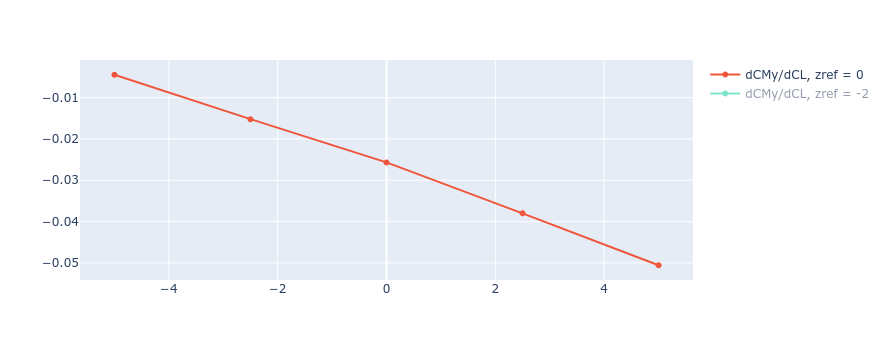

In [36]:
fig = px.line()
fig.add_trace(go.Scatter(
    x=stability['AoA'], 
    y=stability['dCMy/dCL'], name = 'dCMy/dCL, zref = 0'
))
fig.add_trace(go.Scatter(
    x=stability2['AoA'], 
    y=stability2['dCMy/dCL'], name = 'dCMy/dCL, zref = -2'
))
fig.show()

# Work out lift resultant location

In [3]:
path = os.getcwd()
fname = '/home/timbo/myrepos/gitlab/wildcat/VSP/P7Wildcat-240907.vsp3'
vsp.VSPRenew()
vsp.ReadVSPFile((fname))


In [4]:
analyseVLM(AoAStart=0, AoAEnd=0, AlphaNpts=1, Xref = 0, VLM = True, Sref=None)

Wing Reference Parms: 
 Sref:  13.500 
 bref:   9.662 
 cref:   1.438 

/home/timbo/anaconda3/envs/vsppytools/lib/python3.12/site-packages/openvsp/vspaero -omp 16 /home/timbo/myrepos/gitlab/wildcat/VSP/P7Wildcat-240907_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Jul 25 2024 at 05:45:09 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: 0.000000 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.437938 
Bref            = 9.662000 
X_cg            = 0.000000 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = 0.000000 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Symmetry        = Y  
FarDist         = -1.000000 
NumWakeNodes    = 64  
WakeIters       = 6  
NumberOfControlGroups = 0 
NumberOf

'MGAFPMD'

In [5]:
result = getResults()
lodDict = getLod(0)

In [9]:
lod = vsp.FindResultsID("VSPAERO_Load",0)
czs = vsp.GetDoubleResults(lod, 'cz*c/cref',0)

In [23]:
def calcT(dw, dR, h, w, F):
    """Calculate the tension in the sidewire given:
    dw: distance of sidewire from keel
    dR: distance of resultant lift force
    h: height of control frame
    w: half width of control frame
    F: Lift force applied"""
    a = np.arctan(h / (dw-w)) # Angle of sidewire
    #print(np.degrees(a))
    Tvert = F*dR / dw # Vertical component of sidewire tension
    T = Tvert / np.sin(a)
    return T
rootMs = []
for i in range(len(czs)):
    rootMs.append(lodDict['cents'][i].y * czs[i])
M = sum(rootMs)
R = sum(czs)
dR = M/R
print('y location of resultant:', dR)

#dws = np.linspace(2,5,11)
dws = [2.20402, 2.29291]
h = 1.52575
w = 0.6725
F = 6 * 105 * 9.81 / 2
Ts = []
for dw in dws:
    Ts.append(calcT(dw,dR,h,w,F))
print('y location of resultant:', dR)
print('Max force:', F)
Ts

y location of resultant: 2.332723694610665
y location of resultant: 2.332723694610665
Max force: 3090.15


[np.float64(4634.079952892223), np.float64(4586.007568571421)]

In [41]:
dw = 2.20402
ach = 11 #Sweep back angle of xtube in horizontal plane
acv = 4.1 #Dihedral angle of xtube in vertical plane
ats = 17.1 #Angle of tension strop below horizontal
adl = 78.6 #Angle of drop link below horizontal
T = calcT(dw,dR,h,w,F)
print('Tension in sidewire', round(T))
a = np.arctan(h / (dw-w))
print('angle of sidewire to horizontal:', round(np.degrees(a),1))
Fh = T * np.cos(a)
print('Force in horizontal plane:',round(Fh))
Fch = Fh/np.cos(np.radians(ach))
print('Compression force in xtube in horizontal plane',round(Fch))
Fc = Fch/np.cos(np.radians(acv))
print('Axial compression force in xtube',round(Fc))
Fv = Fch * np.tan(np.radians(acv))
print('Vertical force on XT centre joint (per xtube)', round(Fv))
Fpbh = Fh * (np.tan(np.radians(ach)))
print('Horizontal pull back force on XT centre joint (per tube)', round(Fpbh))
Tpb = Fpbh / np.cos(np.radians(ats))
print('Tension in tension strop', round(Tpb))
Tpbv = Fpbh * np.tan(np.radians(ats))
print('Vertical component of tension strop tension', round(Tpbv))
r = Tpbv/Fv
print('Ratio of distance from drop link to back of shackle to distance from DL to CL of XT', round(r,4))

Tension in sidewire 4634
angle of sidewire to horizontal: 44.9
Force in horizontal plane: 3283
Compression force in xtube in horizontal plane 3344
Axial compression force in xtube 3353
Vertical force on XT centre joint (per xtube) 240
Horizontal pull back force on XT centre joint (per tube) 638
Tension in tension strop 668
Vertical component of tension strop tension 196
Ratio of distance from drop link to back of shackle to distance from DL to CL of XT 0.8189


In [42]:
240/6

40.0

In [40]:
float(50/r)


61.05644499915112

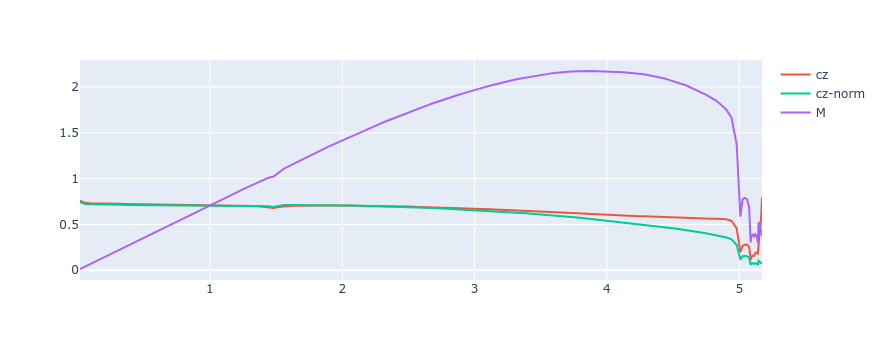

In [11]:
fig = px.line()

fig.add_trace(go.Scatter(
    x = [pt.y for pt in lodDict['cents']],
    y = [pt.z for pt in lodDict['cfs']], name = 'cz'
))
fig.add_trace(go.Scatter(
    x = [pt.y for pt in lodDict['cents']],
    y = czs, name = 'cz-norm'
))
fig.add_trace(go.Scatter(
    x = [pt.y for pt in lodDict['cents']],
    y = rootMs, name = 'M'
))


fig.show()

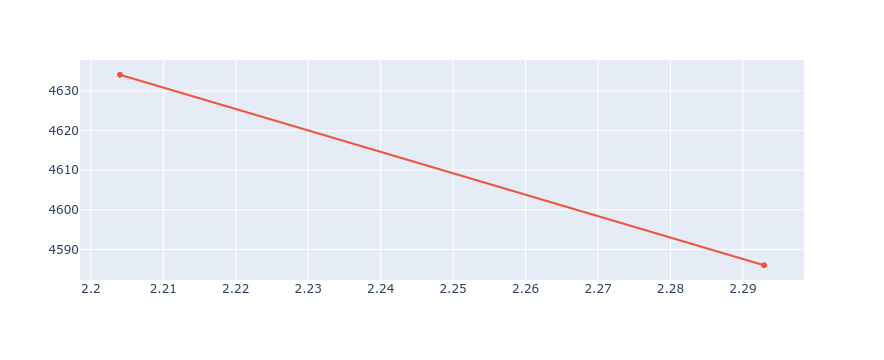

In [12]:
fig = px.line()

fig.add_trace(go.Scatter(
    x = dws,
    y = Ts, name = 'T'
))


fig.show()

In [13]:
dRs = np.linspace(2,3,3)
dws = np.linspace(2,5,11)
h = 1.52575
w = 0.6725
F = 6 * 120 * 9.81 / 2
Ts = []
for dR in dRs:
    Ts.append([])
    for dw in dws:
        Ts[-1].append(calcT(dw,dR,h,w,F))
len(Ts)

48.97464704528374
43.15180420190852
38.364059025030684
34.40961147617585
31.117689840817526
28.351785716717558
26.005421222762738
23.996214717409373
22.260394628092993
20.748342258119518
19.421160647967103
48.97464704528374
43.15180420190852
38.364059025030684
34.40961147617585
31.117689840817526
28.351785716717558
26.005421222762738
23.996214717409373
22.260394628092993
20.748342258119518
19.421160647967103
48.97464704528374
43.15180420190852
38.364059025030684
34.40961147617585
31.117689840817526
28.351785716717558
26.005421222762738
23.996214717409373
22.260394628092993
20.748342258119518
19.421160647967103


3

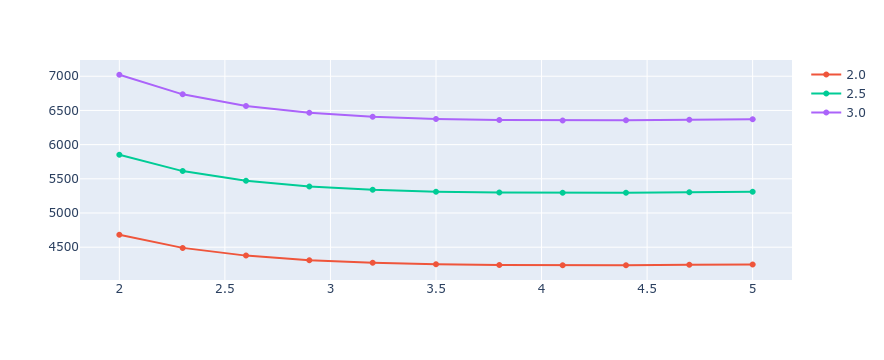

In [55]:
fig = px.line()

for T,dR in zip(Ts,dRs):
    fig.add_trace(go.Scatter(
        x = dws,
        y = T, name = str(dR)
    ))


fig.show()

In [12]:
newTLpts = findBillow(list(allpts['TLpts']), TLFs, Lratio = 0.998, maxiters = 10000,tol = 1e-3)

Tension line length 4.879649841460546
Final length error 4.7769117453489e-07 Final tension error 0.0009703252965874501 Iterations: 245


In [13]:
glider['twists'], calcTwists(allpts['LEpts'],newTLpts)

([0, -3.62, -6.78, -8.9, -11.1, -14.8, -18, -20, -20],
 [-0.0,
  -1.5339927918123137,
  -3.9054591502154294,
  -6.518208296709687,
  -9.56877102575346,
  -13.361695539962895,
  -17.127801021739746,
  -18.132984310183865,
  -18.132984310183865])

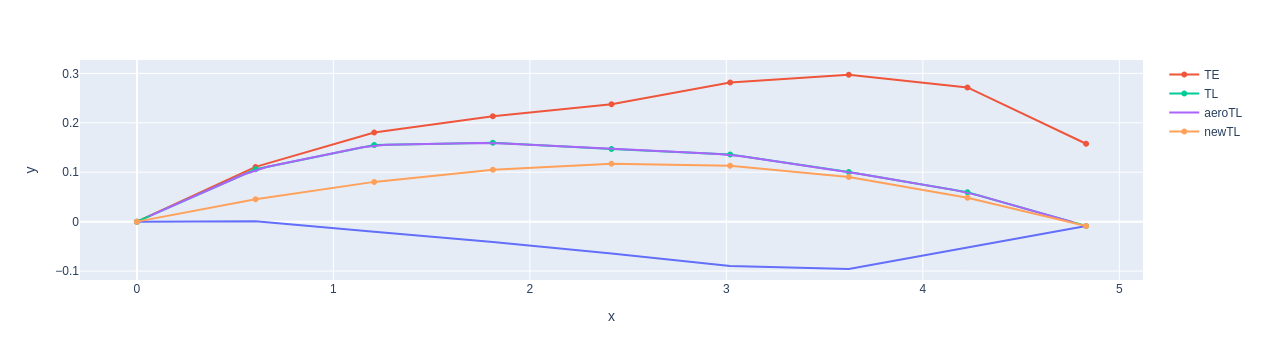

In [14]:
fig = px.line(x=[pt.y for pt in allpts['LEpts']], y=[pt.z for pt in allpts['LEpts']])

fig.add_trace(go.Scatter(
    x = [pt.y for pt in allpts['TEpts']],
    y = [pt.z for pt in allpts['TEpts']], name = 'TE'
))

fig.add_trace(go.Scatter(
    x = [pt.y for pt in allpts['TLpts']],
    y = [pt.z for pt in allpts['TLpts']], name = 'TL'
))

fig.add_trace(go.Scatter(
    x = [pt.y for pt in allpts['aeroTLpts']],
    y = [pt.z for pt in allpts['aeroTLpts']], name = 'aeroTL'
))

fig.add_trace(go.Scatter(
    x = [pt.y for pt in newTLpts],
    y = [pt.z for pt in newTLpts], name = 'newTL'
))

#fig.add_trace(go.Scatter(
#    x = Ycents,
#    y = opt['x'], name = 'optTL'
#))

fig.show()

In [42]:

def iterateBillow(glider, alpha, Lratio, blankfname, AFfolder):
    vsp.VSPRenew()
    glider = dict(glider)
    generateWing(glider, blankfname, AFfolder)
    analyseVLM(AoAStart=alpha, AoAEnd=alpha, AlphaNpts=1, VLM = True, Sref=None)
    lodDict = getLod(0)
    allpts =calcALLpts(glider, lodDict)
    TLFs, tlfs = calcTLF(allpts, lodDict)
    newTLpts = findBillow(list(allpts['TLpts']), TLFs, Lratio, maxiters = 10000,tol = 1e-3)
    glider['twists'] = calcTwists(allpts['LEpts'],newTLpts)
    return glider

def convergeBillow(glider, alpha, Lratio, blankfname, AFfolder, tol = 1e-2,maxiters = 10):
    newglider = dict(glider)
    i = 0
    twistchange = 1
    while twistchange > tol:
        twistsOLD = list(newglider['twists'])
        newglider = iterateBillow(newglider,alpha,Lratio,blankfname, AFfolder)
        twistchange = 0
        for tn,to in zip(newglider['twists'],twistsOLD):
            twistchange += abs(tn-to)
        i+=1
        if i > maxiters:
            break

    if i > maxiters:
        print('*********************************')
        print('BILLOW FAILED TO CONVERGE')
    else:
        print('*******************************')
        print('BILLOW CONVERGED with final error:', twistchange, 'after', i, 'iterations')
    return newglider
    
    

newglider = convergeBillow(glider,alpha=15,Lratio=1,blankfname = (folder+fname), AFfolder=AFfolder)

data/aerofoils/TEMP/0.dat
Wing generated with 8 points Area =  13.893352125
Wing Reference Parms: 
 Sref:  13.500 
 bref:  10.000 
 cref:   1.000 

/home/timbo/anaconda3/envs/vsppytools/lib/python3.10/site-packages/openvsp/vspaero -omp 16 examples/blank1_DegenGeom
VSPAERO v.6.4.8 --- Compiled on: Mar  4 2024 at 07:19:10 PST 




Initializing OPENMP for 16 threads 
NumberOfThreads_: 16 
Mach: 0.000000 
AoA: 15.000000 
ReCref_: 1000000.000000 
Sref            = 13.500000 
Cref            = 1.000000 
Bref            = 10.000000 
X_cg            = 0.000000 
Y_cg            = 0.000000 
Z_cg            = 0.000000 
Mach            = 0.000000 
AoA             = 15.000000 
Beta            = 0.000000 
Vinf            = 100.000000 
Vref            = 100.000000 
Rho             = 0.002377 
ReCref          = 1000000.000000 
ClMax           = 1.600000 
Clo2D           = 0.000000 
MaxTurningAngle = -1.000000 
Symmetry        = Y  
FarDist         = -1.000000 
NumWakeNodes    = 64  
WakeIters       = 

In [40]:
errs

[16.02943714156289,
 1.6221709769941892,
 0.10376842564039457,
 0.00016624946812182628,
 0.00016545112385157879]

In [16]:
lod = vsp.FindResultsID("VSPAERO_Load",0)
vsp.GetAllDataNames(lod)

('AnalysisMethod',
 'Chord',
 'FC_AoA_',
 'FC_Beta_',
 'FC_Bref_',
 'FC_Cref_',
 'FC_Mach_',
 'FC_Pitch_Rate',
 'FC_Rho_',
 'FC_Roll__Rate',
 'FC_Sref_',
 'FC_Vinf_',
 'FC_Xcg_',
 'FC_Yaw___Rate',
 'FC_Ycg_',
 'FC_Zcg_',
 'S',
 'V/Vref',
 'WingId',
 'Xavg',
 'Yavg',
 'Zavg',
 'cd',
 'cd*c/cref',
 'cl',
 'cl*c/cref',
 'cmx',
 'cmx*c/cref',
 'cmy',
 'cmy*c/cref',
 'cmz',
 'cmz*c/cref',
 'cs',
 'cs*c/cref',
 'cx',
 'cx*c/cref',
 'cy',
 'cy*c/cref',
 'cz',
 'cz*c/cref')

In [129]:
def billowErr(zs,zstart, zend, xs,ys,Ltarget,P):
    assert len(xs) == len(zs) + 2
    assert len(ys) == len(zs) + 2
    assert len(P) ==len(zs)
    L = 0
    TLpts = [P3(xs[0],ys[0],zstart)]
    for i in range(len(zs)):
        TLpts.append(P3(xs[i+1],ys[i+1],zs[i]))
    TLpts.append(P3(xs[-1],ys[-1],zend))
    for i in range(1,len(TLpts)):
        L += (TLpts[i]-TLpts[i-1]).Len()
    
    L_err = abs(Ltarget-L)/Ltarget
    print(L,Ltarget,L_err)
    #Calc tension at each point 
    Ts = []
    for i in range(1,len(TLpts)-1):
        v1 = TLpts[i]-TLpts[i-1]
        v2 = TLpts[i+1]-TLpts[i]
        ac = P3.Dot(v1,v2)/(v1.Len()*v2.Len())
        if ac > 1:
            a = 0
        else:
            a = np.arccos(ac)
        #print('angle',np.degrees(a))
        if P3.Cross(v1,v2).y < 0:
            a = -a
        if a == 0:
            T = 0
        else:
            T = P[i-1]/(2*np.sin(a/2))
        #SIMPLIFIED USING TRIG IDENTITIES
        #c = P3.Dot(v1,v2)/(v1.Len()*v2.Len())
        #s = np.sqrt((1 - c)/2)
        #T = P[i] / (2*s)
        Ts.append(T)
        #print(np.degrees(a),T)
    T_av = np.mean(Ts)
    T_err = abs((max(Ts)-T_av)/T_av)
    print(T_av,max(Ts),T_err)

    return L_err + T_err

In [130]:
xs = list(aeroTLxs)
xs.insert(0,TLpts[0].x)
xs.append(TLpts[-1].x)
ys = list(Ycents)
ys.insert(0,TLpts[0].y)
ys.append(TLpts[-1].y)

length = 4880

billowErr(zs=opt['x'], zstart=TLpts[0].z, zend=TLpts[-1].z, xs=xs,ys=ys,Ltarget = length, P = tlfs)


4879.7354177027855 4880 5.4217683855425046e-05
-762.5244966312414 25484454.17224401 33422.16126738463


33422.16132160232

In [131]:
opt = scipy.optimize.minimize(billowErr,
                              aeroTLzs,
                              method = 'Nelder-Mead',
                              args=(TLpts[0].z, TLpts[-1].z, xs, ys,length-100, tlfs),
                              tol = 1e-6
                             )
opt

4879.423724969141 4780 0.020799942462163473
798318.0633875628 20270784.79813828 24.391865382729463
4879.42723957179 4780 0.020800677734684074
798317.2912862891 20270784.79813828 24.391889940748957
4879.444314133802 4780 0.020804249818787122
798317.4504523989 20270784.79813828 24.391884878191025
4879.480271905469 4780 0.02081177236516082
798317.6937349135 20270784.79813828 24.391877140166862
4879.533635893355 4780 0.020822936379362885
798318.4215800305 20270784.79813828 24.391853989813207
4879.795400124524 4780 0.020877698770820994
798318.2349233933 20270784.79813828 24.391859926741454
4879.962826958437 4780 0.020912725305112404
798316.9532551814 20270784.79813828 24.39190069242929
4879.724475250619 4780 0.020862860931091933
798320.7468715389 20270784.79813828 24.39178003023907
4879.774951931236 4780 0.02087342090611623
379145.33007978054 20270784.79813828 52.46441902336727
4879.82911470894 4780 0.020884752031159064
379144.91969824827 20270784.79813828 52.46447689255938
4880.02197875526

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1.020923219065584
             x: [ 1.111e+01  3.234e+01 ...  4.405e+01  3.140e+01]
           nit: 771
          nfev: 8000
 final_simplex: (array([[ 1.111e+01,  3.234e+01, ...,  4.405e+01,
                         3.140e+01],
                       [ 1.111e+01,  3.234e+01, ...,  4.405e+01,
                         3.140e+01],
                       ...,
                       [ 1.111e+01,  3.234e+01, ...,  4.405e+01,
                         3.140e+01],
                       [ 1.111e+01,  3.234e+01, ...,  4.405e+01,
                         3.140e+01]]), array([ 1.021e+00,  1.021e+00, ...,  1.021e+00,  1.021e+00]))

In [132]:
opt['x']

array([ 11.10815293,  32.34019122,  53.34656288,  74.18425788,
        94.97176016, 110.31057402, 119.93065466, 129.44972515,
       139.02034334, 148.52393427, 155.83934329, 156.65956685,
       157.47679456, 158.29794838, 158.98128541, 159.76578651,
       157.32810926, 154.85379935, 152.42945447, 149.95576538,
       147.55829743, 145.4193916 , 143.43409939, 141.37477368,
       139.42310117, 137.39549654, 133.66942879, 126.94652785,
       120.72857345, 114.14296816, 108.2749509 , 101.44088377,
        94.50924392,  86.79505959,  75.98219328,  72.62012786,
        65.2709972 ,  55.2318083 ,  44.05070537,  31.4017356 ])

In [122]:
billowErr(zs=opt['x'], zstart=TLpts[0].z, zend=TLpts[-1].z, xs=xs,ys=ys,Ltarget = length, P = tlfs)

4879.7354177027855 4880 5.4217683855425046e-05


-33422.161213166946

In [22]:
rho = 1.225
v = 26 * 0.44704
q = 0.5 * rho * v**2
CL = result['CL'][0]
Sref = vsp.GetDoubleResults(lod, 'FC_Sref_',0)[0]

L = CL*(q*Sref)

Ls =[]
for i in range(len(cls)):
    sr = chords[i]*spansecs[i]
    Ls.append(cls[i]*(q*sr))
L,np.sum(Ls)*2

(753.5815869800513, 742.9589939843826)

In [23]:
rho = 1.225
v = 26 * 0.44704
q = 0.5 * rho * v**2
CM = result['CMy'][0]
Sref = vsp.GetDoubleResults(lod, 'FC_Sref_',0)[0]

M = CM*(q*Sref)

Ms =[]
cmys = vsp.GetDoubleResults(lod, 'cmy*c/cref',0)
for i in range(len(cmys)):
    sr = chords[i]*spansecs[i]
    Ms.append(cmys[i]*(q*sr))
M, np.sum(Ms)*2

(-944.8293580344017, -925.2753667378736)

In [33]:
def calcLTEpts(secs,chordsmm,sweeps,dihedrals,twists):
    LEpts = [P3(0,0,0)]
    for i in range(1,len(secs)):
        d = np.tan(np.radians(sweeps[i-1]))*(secs[i]-secs[i-1])
        h = np.tan(np.radians(dihedrals[i-1]))*(secs[i]-secs[i-1])
        LEpts.append(P3((LEpts[-1].x+d),(secs[i]),(LEpts[-1].z+h)))
    
    TEpts = []
    for i in range(len(LEpts)):
        TEpts.append(P3(
            LEpts[i].x + (chordsmm[i]*np.cos(np.radians(twists[i]))),
            LEpts[i].y,
            LEpts[i].z - (chordsmm[i]*np.sin(np.radians(twists[i])))))
    return LEpts, TEpts

def calcTLpts(LEpts,TEpts):
    #Vector of tension line from root trailing edge to tip leading edge
    vTL = LEpts[-1] - TEpts[0]
    
    #List of points along tension line
    TLpts = []
    for i in range(len(LEpts)):
        vChL = TEpts[i] - LEpts[i] #Vector of chord line
        r = LEpts[i].y / LEpts[-1].y - LEpts[0].y #ratio of distance along y axis
        x = TEpts[0].x + r*vTL.x
        y = LEpts[i].y
        rc = (x - LEpts[i].x)/(TEpts[i].x - LEpts[i].x)
        z = LEpts[i].z + rc*vChL.z
        TLpts.append(P3(x,y,z))
    return TLpts

def calcTwists(LEpts,TLpts):
    twists = []
    for i in range(len(LEpts)-1):
        vLETL = TLpts[i] - LEpts[i]
        twists.append(-np.degrees(np.arctan(vLETL.z/vLETL.x)))
    twists.append(twists[-1])
    return twists



In [17]:
vsp.GetAllResultsNames ()

('CpSlice_Wrapper',
 'CpSlicer_Case',
 'VSPAERO_Comp_Load',
 'VSPAERO_History',
 'VSPAERO_Load',
 'VSPAERO_Polar',
 'VSPAERO_Setup',
 'VSPAERO_Wrapper')

In [8]:
resultDict = {
    'Xavg': vsp.GetDoubleResults(lod, 'Xavg',0),
    'Yavg': vsp.GetDoubleResults(lod, 'Yavg',0),
    'Zavg': vsp.GetDoubleResults(lod, 'Zavg',0),
    'cl': vsp.GetDoubleResults(lod, 'cl',0),
    'cd': vsp.GetDoubleResults(lod, 'cd',0),
    'cs': vsp.GetDoubleResults(lod, 'cs',0),
    'cx': vsp.GetDoubleResults(lod, 'cx',0),
    'cy': vsp.GetDoubleResults(lod, 'cy',0),
    'cz': vsp.GetDoubleResults(lod, 'cz',0),
    'cx*c/cref': vsp.GetDoubleResults(lod, 'cx*c/cref',0),
    'cy*c/cref': vsp.GetDoubleResults(lod, 'cy*c/cref',0),
    'cz*c/cref': vsp.GetDoubleResults(lod, 'cz*c/cref',0),
    'cmx': vsp.GetDoubleResults(lod, 'cmx',0),
    'cmy': vsp.GetDoubleResults(lod, 'cmy',0),
    'cmz': vsp.GetDoubleResults(lod, 'cmz',0),
    'cmx*c/cref': vsp.GetDoubleResults(lod, 'cmx*c/cref',0),
    'cmy*c/cref': vsp.GetDoubleResults(lod, 'cmy*c/cref',0),
    'cmz*c/cref': vsp.GetDoubleResults(lod, 'cmz*c/cref',0)
}

import json
out_file = open("temp-lod.json", "w") 
  
json.dump(resultDict, out_file, indent = 6) 
  
out_file.close() 

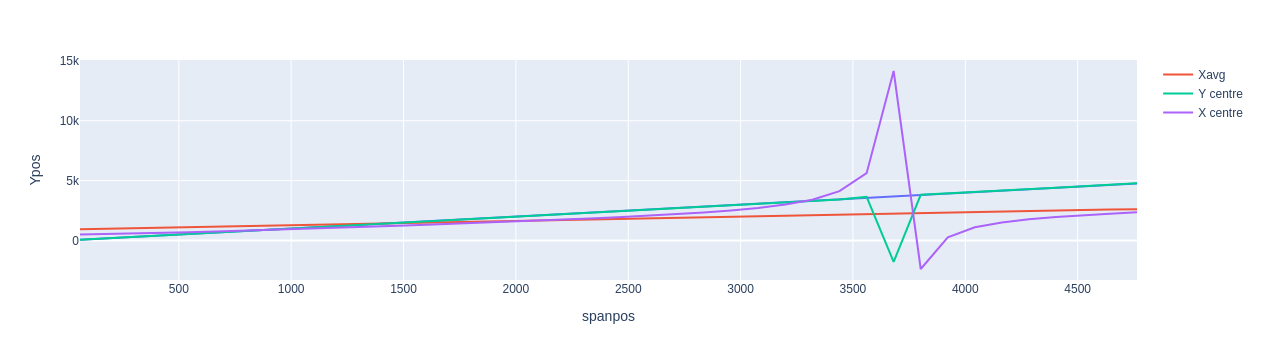

In [18]:

fig = px.line(x= Ys, y = Ys)
fig.add_trace(go.Scatter(x = Ys, y=Xs, name = 'Xavg'))
fig.add_trace(go.Scatter(x = Ys, y=Ycents, name = 'Y centre'))
fig.add_trace(go.Scatter(x = Ys, y=Xcents, name = 'X centre'))

fig.update_yaxes(title_text='Ypos')
fig.update_xaxes(title_text='spanpos')
fig.show()

In [10]:
#Xcents = []
#Ycents = []
#XcentsOLD = []
#YcentsOLD = []

for i in range(len(Ys)):
    pos = Crz(P3(cxs[i],cys[i],czs[i]),P3(cmxs[i],cmys[i],cmzs[i]),Zs[i])*1000
    Xcents.append(pos.x)
    Ycents.append(pos.y)
    #XcentsOLD.append((-cmys[i]/czs[i])*1000) # !!!THIS NOW SEEMS BETTER THAN USING CL. CROSS CHECK IN DIFFERENT AXES IF POSSIBLE THOUGH!!!!!
    #YcentsOLD.append((cmxs[i]/czs[i])*1000)
Ys = np.array(Ys)*1000
Xs = np.array(Xs)*1000

NameError: name 'Xcents' is not defined

In [16]:
LEpts,TEpts = calcLTEpts(np.array(glider['secs'])/1000,
                               np.array(glider['chordsmm'])/1000,
                               glider['sweeps'],
                               glider['dihedrals'],
                               glider['twists'])
TLpts = calcTLpts(LEpts,TEpts)
length = 0
for i in range(1,len(TLpts)):
    length += (TLpts[i]-TLpts[i-1]).Len()
print('length', length)
LExs, LEys = [],[]
for pt in LEpts:
    LExs.append(pt.x)
    LEys.append(pt.y)

TLxs, TLys, TLzs = [],[],[]
for pt in TLpts:
    TLxs.append(pt.x)
    TLys.append(pt.y)
    TLzs.append(pt.z)

# Find points at LE and TL at the Y stations corresponding to the aero centres
aeroLExs = np.interp(Ycents, LEys, LExs)
aeroTLxs = np.interp(Ycents, TLys, TLxs)
aeroTLzs = np.interp(Ycents, TLys, TLzs)
aeroTLpts = []
for i in range(len(aeroTLxs)):
    aeroTLpts.append(P3(aeroTLxs[i],Ycents[i], aeroTLzs[i]))
aeroTLpts.insert(0,TLpts[0])
aeroTLpts.append(TLpts[-1])

# Find distance in x from LE to aero centres and to tension line
Dcls, Dtls = [], []
for i in range(len(aeroLExs)):
    Dcls.append(Xcents[i]-aeroLExs[i])
    Dtls.append(aeroTLxs[i]-aeroLExs[i])
    
# Work out forces on tension line:
tlfs = []
for i in range (len(cls)):
    tlfs.append(Dcls[i]*cls[i]/Dtls[i])

TLFs = np.interp(TLys, Ycents, tlfs)
    

length 4.879649841460546


NameError: name 'Ycents' is not defined